# Automatic Music Composition with RNN
# Uses Keras interface,  TensorFlow backend and Music21
# Dataset:  Guitar God **Steve Vai's** music scores. 

This notebook pretends to create a model  for automatic music compostion. 
It will create a song based on the training input. For training we have used  **Steve Vai's songs** in midi format. Music21 will be used to convert midi files into training data. Actually, there are two models, one for the notes and other for the duration of each note. 

We will use a RNN, LSTM, with timestep = 7 and around 30K sequences of training data.

In the experiment, we will provide the first 7 notes of a well known Steve Vai's song: "For the love of god", and we will check what the model composes with those 7 notes as an input. We have the original song to compare.

There are many challenges here, but some of them for further work:
* The guitar scores have melodies and solos. The solos' parts have notes of very short duration, played very fast and very repetitive. Future work, will build models for melody and soloing - however there is not a clear boundary when building a solo or when building a melody
* The possible notes are given by the key of the song. If we are in Em, there are a set of allowed notes and other not allowed. The model is trained with the whole Vai's scores, who are in many different keys, hence keeping the tune is up for the model to have learned. Future work will explore working with intervals instead of notes themselves.
* Keeping a melody must remain estable in duration with no ups and down in duration, I will explore ways to have a melody built-up through the model.





In [ ]:
!pip install music21



In [ ]:
!pip install keras

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import music21	
	


In [ ]:
import glob
from music21 import converter, instrument, note, chord, midi
 
#midi_path= "ForTheLoveofGod.mid"
midi_path= "/content/sample_data/MIDI/beethoven-tarrega-moonlight-sonata1-guitar.mid"

notes = []
chords = []
duration = []
notes_to_parse = None

for file in glob.glob(midi_path):
    print("--------------------------------------------")
    print("Reading midi file: ", file)
#Read MIDI

    mf = midi.MidiFile()
    mf.open(file)
    mf.read()
    mf.close()
    
#List song parts
    midix = midi.translate.midiFileToStream(mf)
    partStream = midix.parts.stream()
    print("List of instruments found on MIDI file: ",file)
    for p in partStream:
        aux = p
        print (p.partName)

#info about the song

    parts = midix.parts.stream()

    print("Elements of the MIDI: ",midix.elements)
    print("Parts of the MIDI: ",parts)
    print("LEN parts:", len(parts))

#extracting the melody part 

    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes flat structure
        notes_to_parse = midi.flat.notes

#parse notes,duration an chords

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
            duration.append(str(element.duration.quarterLength))
        elif isinstance(element, chord.Chord):
            chords.append('.'.join(str(n) for n in element.normalOrder))

    #print("DURATION:", duration)
    #print("CHORD: ",chords)
    print("Total ",len(notes)," NOTES.")

        



--------------------------------------------
Reading midi file:  /content/sample_data/MIDI/beethoven-tarrega-moonlight-sonata1-guitar.mid
List of instruments found on MIDI file:  /content/sample_data/MIDI/beethoven-tarrega-moonlight-sonata1-guitar.mid
None
Elements of the MIDI:  (<music21.stream.Part 0x7f7ebf682d68>,)
Parts of the MIDI:  <music21.stream.Score 0x7f7ebf5f1320>
LEN parts: 1
Total  919  NOTES.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: ignored

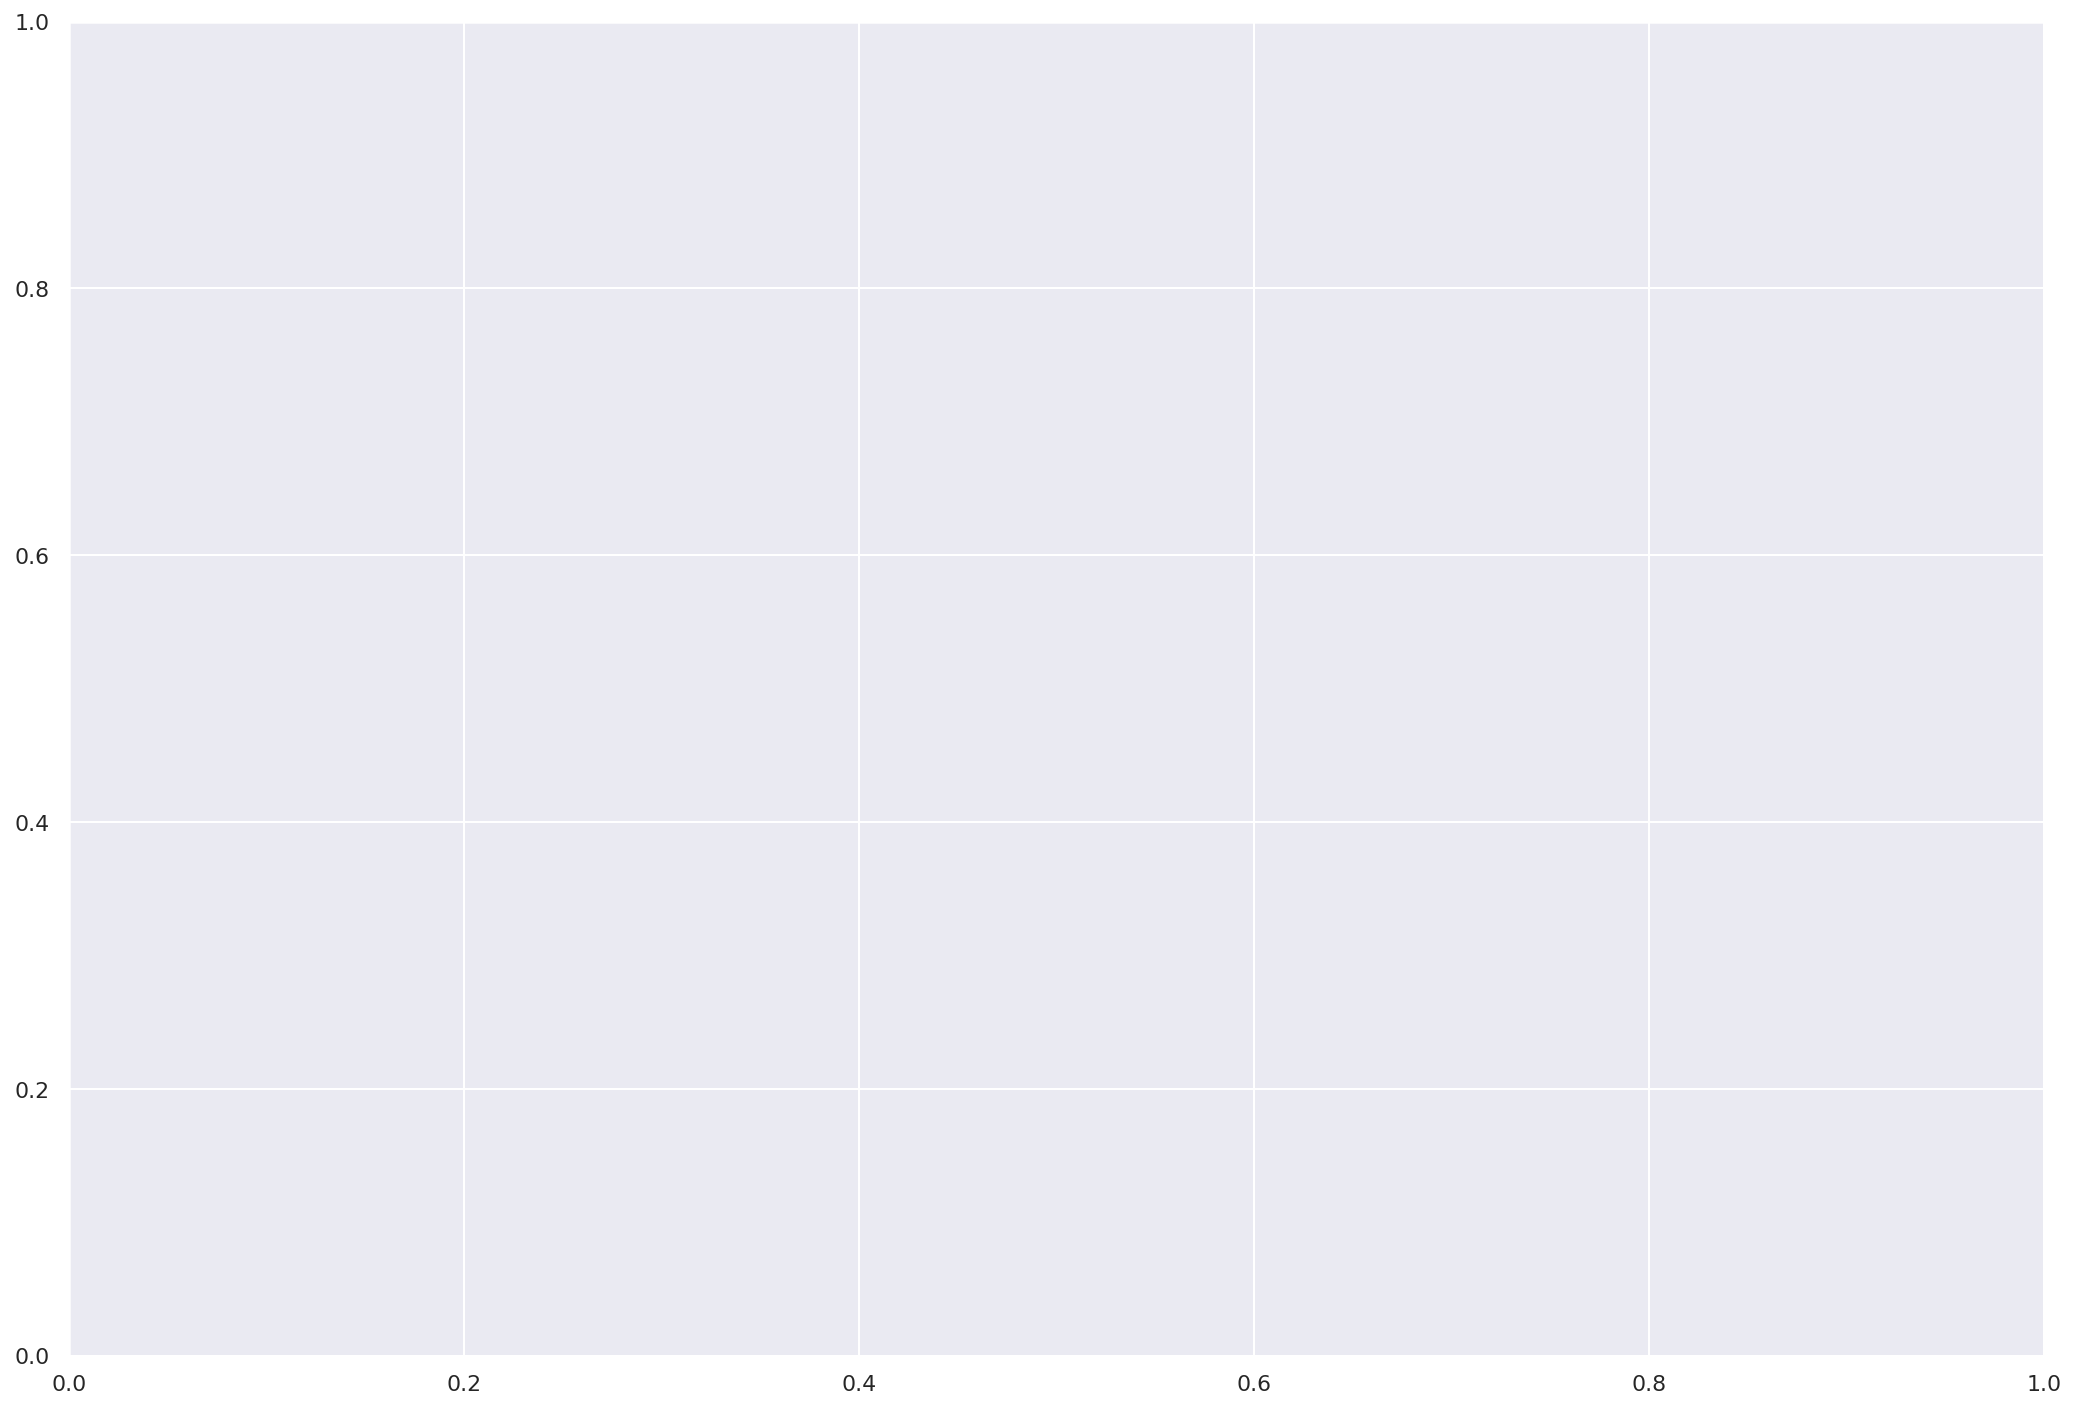

In [ ]:
# Distribution of notes - let's display it
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(17.7,12.27)})
sns.distplot(notes, hist=True, kde=False, bins=104, color = 'blue',hist_kws={'edgecolor':'black'})


# NOTES: Create the training sequences and training the model for predicting notes, taking in account the 10 notes played before

In [ ]:
#convert notes to numbers via dictionary


allnotes = sorted(set(item for item in notes))
print ("All notes in the song:")
print(allnotes)

#make a dict

notedict = dict((note, number) for number, note in enumerate(allnotes))
print ("Dictionary Created:")
print(notedict)
vocab = len(notedict)

#prepare sequences for training.

sequence_length = 7
ninput = []
noutput = [] 

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    ninput.append([notedict[char] for char in sequence_in])
    noutput.append(notedict[sequence_out])
    
patterns = len(ninput)
print("")
print("Number of sequences: ",patterns)
print("")
print("Example of sequence created:")
print(ninput[116],"->--next note: --> ",noutput[116])
print(ninput[17],"->--next note: --> ",noutput[17])

# We need a copy not normalized of the input sequences for the prediction later on

ninputclean = ninput


All notes in the song:
['A2', 'A3', 'A4', 'A5', 'B-2', 'B-3', 'B-4', 'B3', 'B4', 'B5', 'C#3', 'C#4', 'C#5', 'C3', 'C4', 'C5', 'D2', 'D3', 'D4', 'D5', 'E-3', 'E-4', 'E3', 'E4', 'E5', 'F#2', 'F#3', 'F#4', 'F2', 'F3', 'F4', 'F5', 'G#2', 'G#3', 'G#4', 'G#5', 'G2', 'G3', 'G4']
Dictionary Created:
{'A2': 0, 'A3': 1, 'A4': 2, 'A5': 3, 'B-2': 4, 'B-3': 5, 'B-4': 6, 'B3': 7, 'B4': 8, 'B5': 9, 'C#3': 10, 'C#4': 11, 'C#5': 12, 'C3': 13, 'C4': 14, 'C5': 15, 'D2': 16, 'D3': 17, 'D4': 18, 'D5': 19, 'E-3': 20, 'E-4': 21, 'E3': 22, 'E4': 23, 'E5': 24, 'F#2': 25, 'F#3': 26, 'F#4': 27, 'F2': 28, 'F3': 29, 'F4': 30, 'F5': 31, 'G#2': 32, 'G#3': 33, 'G#4': 34, 'G#5': 35, 'G2': 36, 'G3': 37, 'G4': 38}

Number of sequences:  912

Example of sequence created:
[30, 0, 30, 29, 18, 29, 22] ->--next note: -->  5
[5, 30, 5, 30, 5, 38, 5] ->--next note: -->  38


In [ ]:
import numpy
from keras.utils import np_utils

# Convert it to numPy

ninput = numpy.reshape(ninput, (patterns, sequence_length, 1))

# normalize input
ninput = ninput / float(vocab)

#Preparare Output for Neural Network, sparse vector format.
print('example output before categorical')
print(noutput[13])
noutput = np_utils.to_categorical(noutput)
print('example output after categorical')

print(noutput[13])

example output before categorical
30
example output after categorical
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# create the model itself

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed
from keras.optimizers import Adam, RMSprop

print("Shape of input matrix:")
print(ninput.shape[1], ninput.shape[2])
print("Shape of Output:")
print(vocab)
model = Sequential()
model.add(LSTM(
        256,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        return_sequences=True, 
    ))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=False))
#model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(vocab))
model.add(Activation('softmax'))

rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model.add(TimeDistributed(Dense(vocab, activation='sigmoid')))
model.compile(loss='categorical_crossentropy', optimizer=rms,  metrics=['accuracy'])
model.summary()

Shape of input matrix:
7 1
Shape of Output:
39
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 256)            264192    
_________________________________________________________________
dropout (Dropout)            (None, 7, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 128)            197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_3 (L

In [ ]:
# Train implementing callbacks

import keras

# Implementing callbacks to save model after each epoch, just in case not used by now cholo
savepath = "weights-stage-{epoch:02d}-{loss:.4f}-model.hdf5"    
checkpoint = keras.callbacks.ModelCheckpoint(
    savepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = model.fit(ninput, noutput, epochs=1000, batch_size=512, validation_split=0.05)
scores = model.evaluate(ninput,noutput)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Epoch 1/1000
2/2 [==============================] - 2s 1s/step - loss: 3.6588 - accuracy: 0.0370 - val_loss: 3.5649 - val_accuracy: 0.0870
Epoch 2/1000
2/2 [==============================] - 1s 278ms/step - loss: 3.4984 - accuracy: 0.0866 - val_loss: 3.1206 - val_accuracy: 0.1522
Epoch 3/1000
2/2 [==============================] - 1s 281ms/step - loss: 3.6687 - accuracy: 0.0670 - val_loss: 3.0213 - val_accuracy: 0.1522
Epoch 4/1000
2/2 [==============================] - 1s 274ms/step - loss: 3.2347 - accuracy: 0.0704 - val_loss: 2.9577 - val_accuracy: 0.0652
Epoch 5/1000
2/2 [==============================] - 1s 272ms/step - loss: 3.2132 - accuracy: 0.0958 - val_loss: 2.9564 - val_accuracy: 0.1957
Epoch 6/1000
2/2 [==============================] - 1s 279ms/step - loss: 3.1968 - accuracy: 0.0843 - val_loss: 2.9815 - val_accuracy: 0.1304
Epoch 7/1000
2/2 [==============================] - 1s 285ms/step - loss: 3.1936 - accuracy: 0.0855 - val_loss: 3.0131 - val_accuracy: 0.1957
Epoch 8/1

KeyError: ignored

In [ ]:
from keras.models import load_model

model.save('automusicNotes_model.h5')  # creates a HDF5 file 'my_model.h5'


---

# DURATION OF NOTES: Now let's create training sequences and train a model to predict duration of the notes

In [ ]:
#convert notes to numbers via dictionary


allduration = sorted(set(item for item in duration))
print ("All different durations in the song:")
print(allduration)

#make a dict

durationdict = dict((note, number) for number, note in enumerate(allduration))
print ("Dictionary Created:")
print(durationdict)
vocabd = len(durationdict)

#prepare sequences for training.

sequence_length = 7
ninput = []
noutput = [] 

for i in range(0, len(duration) - sequence_length, 1):
    sequence_in = duration[i:i + sequence_length]
    sequence_out = duration[i + sequence_length]
    ninput.append([durationdict[char] for char in sequence_in])
    noutput.append(durationdict[sequence_out])
patterns = len(ninput)
print("")
print("Number of sequences: ",patterns)
print("")
print("Example of sequence created:")
print(ninput[15],"->--next diuration: --> ",noutput[15])
print(ninput[16],"->--next diuration: --> ",noutput[16])
print(ninput[17],"->--next diuration: --> ",noutput[17])



All different durations in the song:
['0.25', '0.75', '1.0', '1/3', '2.0', '2.75', '3.0', '4.0']
Dictionary Created:
{'0.25': 0, '0.75': 1, '1.0': 2, '1/3': 3, '2.0': 4, '2.75': 5, '3.0': 6, '4.0': 7}

Number of sequences:  912

Example of sequence created:
[3, 3, 3, 3, 3, 3, 3] ->--next diuration: -->  3
[3, 3, 3, 3, 3, 3, 3] ->--next diuration: -->  3
[3, 3, 3, 3, 3, 3, 3] ->--next diuration: -->  3


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


ValueError: ignored

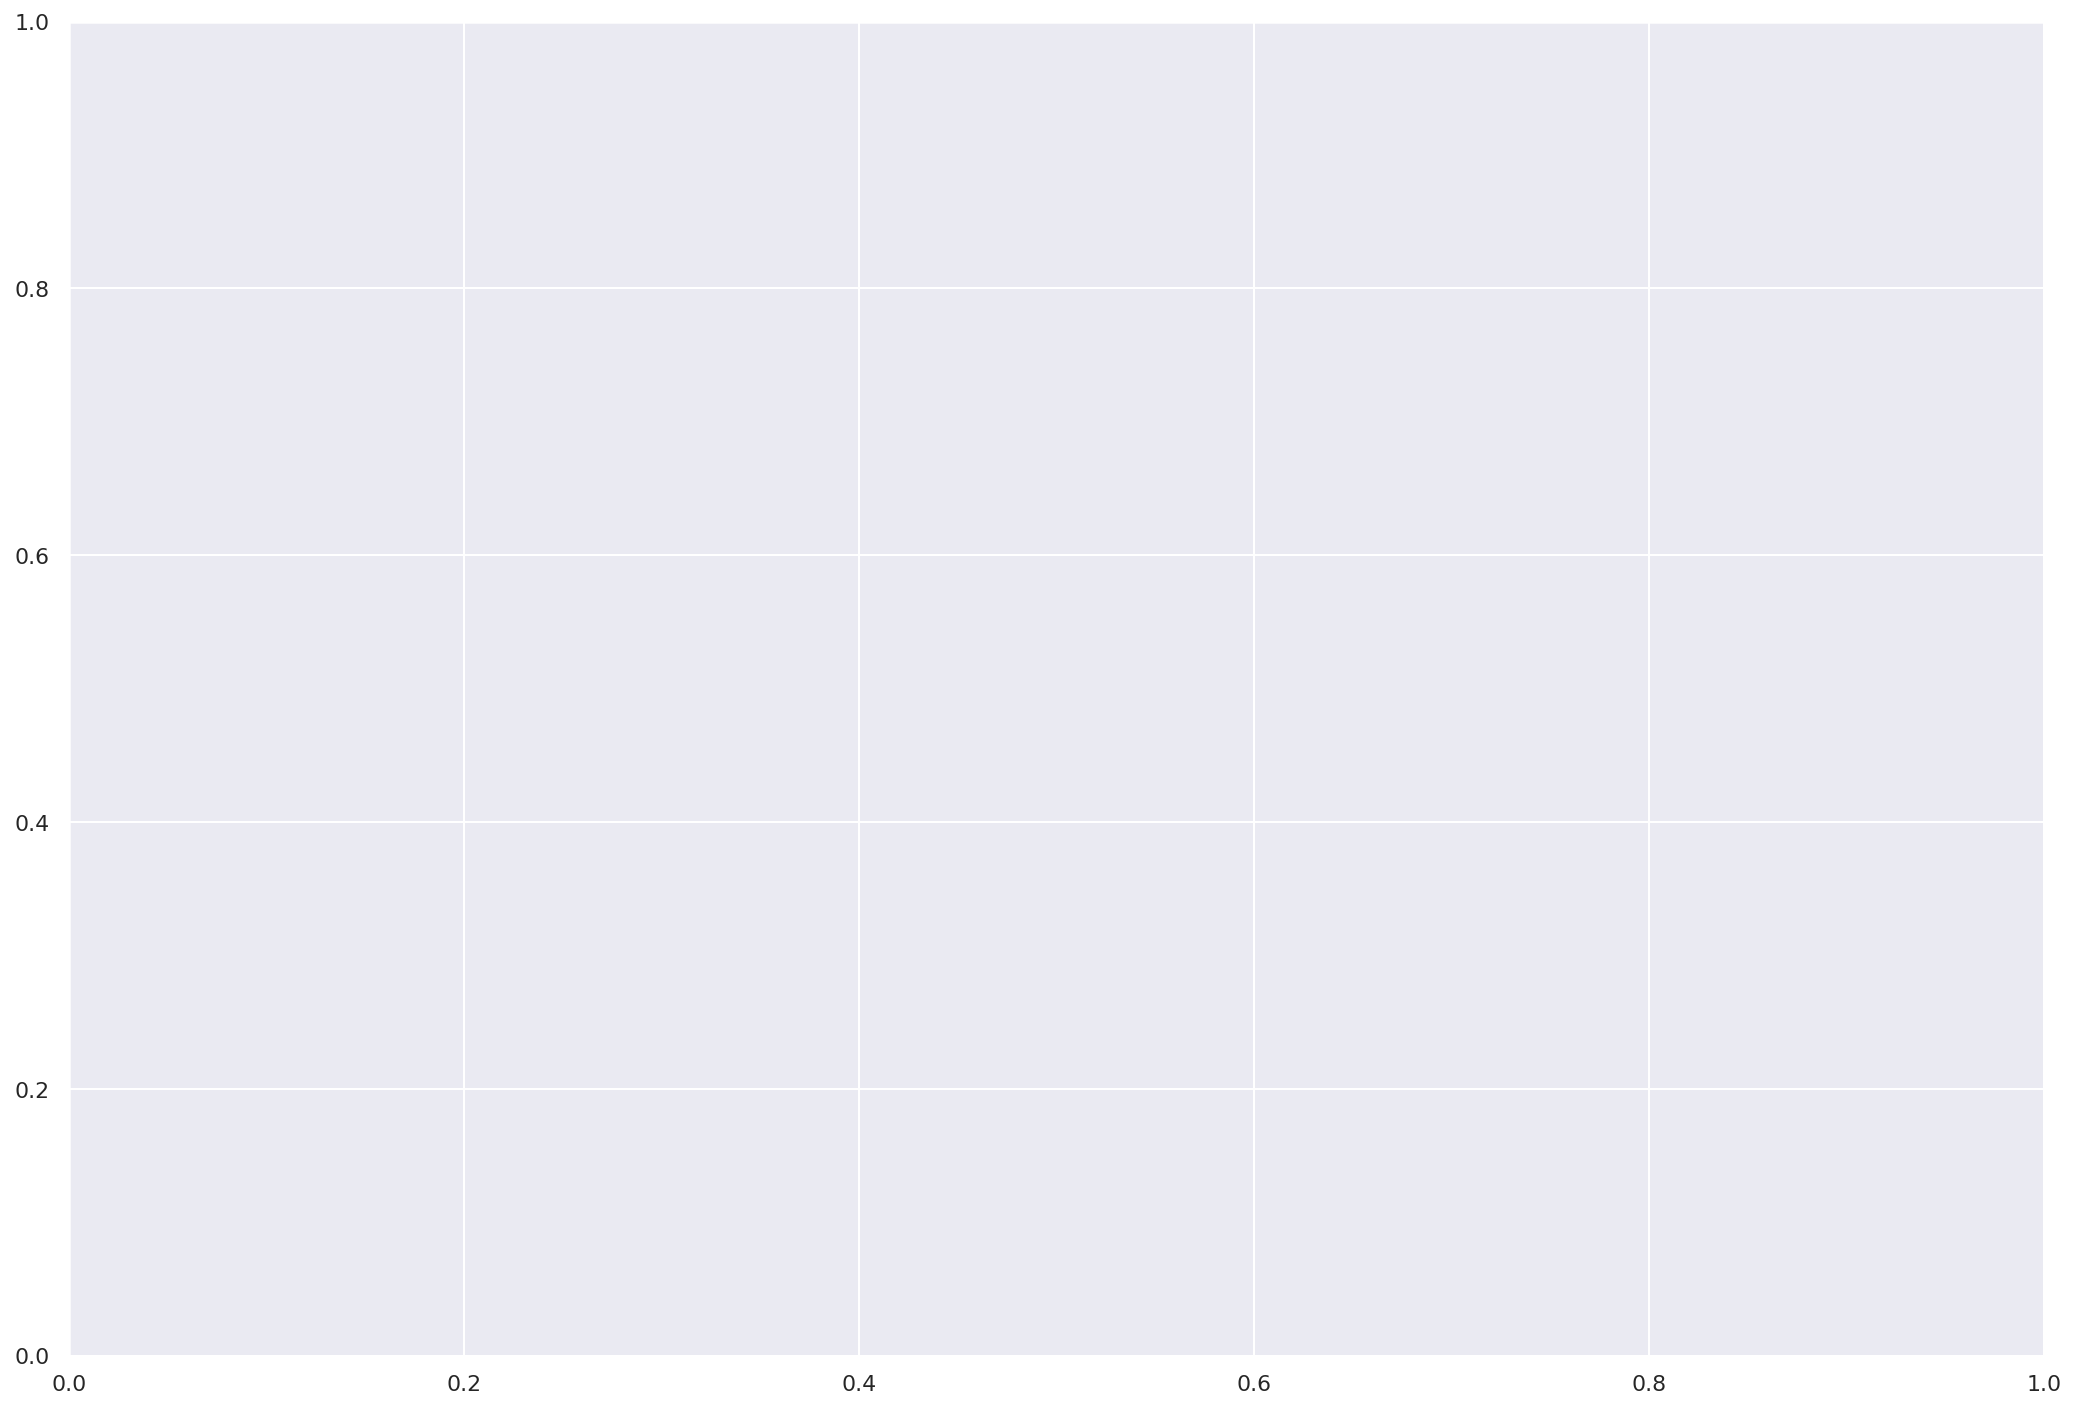

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(17.7,12.27)})
sns.distplot(duration, hist=True, kde=False, 
             bins=104, color = 'blue',hist_kws={'edgecolor':'black'})


In [ ]:
import numpy
from keras.utils import np_utils

# Convert it to numPy

ninput = numpy.reshape(ninput, (patterns, sequence_length, 1))

# normalize input
ninput = ninput / float(vocabd)

#Preparare Output for Neural Network, sparse vector format.

print('example output before categorical')
print(noutput[15])
noutput = np_utils.to_categorical(noutput)
print('example output after categorical')

print(noutput[15])


example output before categorical
3
example output after categorical
[0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, TimeDistributed
from keras.optimizers import Adam, RMSprop

print("Shape of input matrix:")
print(ninput.shape[1], ninput.shape[2])
print("Shape of Output:")
print(vocab)
modeld = Sequential()
modeld.add(LSTM(
        256,
        input_shape=(ninput.shape[1], ninput.shape[2]),
        return_sequences=True, 
    ))
modeld.add(Dropout(0.3))
modeld.add(LSTM(256, return_sequences=True))
modeld.add(Dropout(0.3))
modeld.add(LSTM(128, return_sequences=True))
modeld.add(Dropout(0.3))
modeld.add(LSTM(128, return_sequences=True))
modeld.add(Dropout(0.2))
modeld.add(LSTM(256,return_sequences=False))
#model.add(Dense(256))
modeld.add(Dropout(0.2))
modeld.add(Dense(noutput.shape[1]))
modeld.add(Activation('softmax'))

rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

#model.add(TimeDistributed(Dense(vocab, activation='sigmoid')))
modeld.compile(loss='categorical_crossentropy', optimizer=rms,  metrics=['accuracy'])
modeld.summary()

Shape of input matrix:
7 1
Shape of Output:
39
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 256)            264192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 256)            525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 256)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 128)            197120    
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 128)            0         
_________________________________________________________________
lstm_8 

Epoch 1/60
2/2 [==============================] - 2s 1s/step - loss: 2.0457 - accuracy: 0.4088 - val_loss: 1.4474 - val_accuracy: 0.9348
Epoch 2/60
2/2 [==============================] - 1s 280ms/step - loss: 1.3860 - accuracy: 0.8152 - val_loss: 1.2893 - val_accuracy: 0.9348
Epoch 3/60
2/2 [==============================] - 1s 280ms/step - loss: 1.1688 - accuracy: 0.8152 - val_loss: 0.4078 - val_accuracy: 0.9348
Epoch 4/60
2/2 [==============================] - 1s 282ms/step - loss: 0.8018 - accuracy: 0.8152 - val_loss: 0.4220 - val_accuracy: 0.9348
Epoch 5/60
2/2 [==============================] - 1s 277ms/step - loss: 0.8241 - accuracy: 0.8152 - val_loss: 0.4319 - val_accuracy: 0.9348
Epoch 6/60
2/2 [==============================] - 1s 279ms/step - loss: 0.8220 - accuracy: 0.8152 - val_loss: 0.4349 - val_accuracy: 0.9348
Epoch 7/60
2/2 [==============================] - 1s 271ms/step - loss: 0.7774 - accuracy: 0.8152 - val_loss: 0.4575 - val_accuracy: 0.9348
Epoch 8/60
2/2 [=======

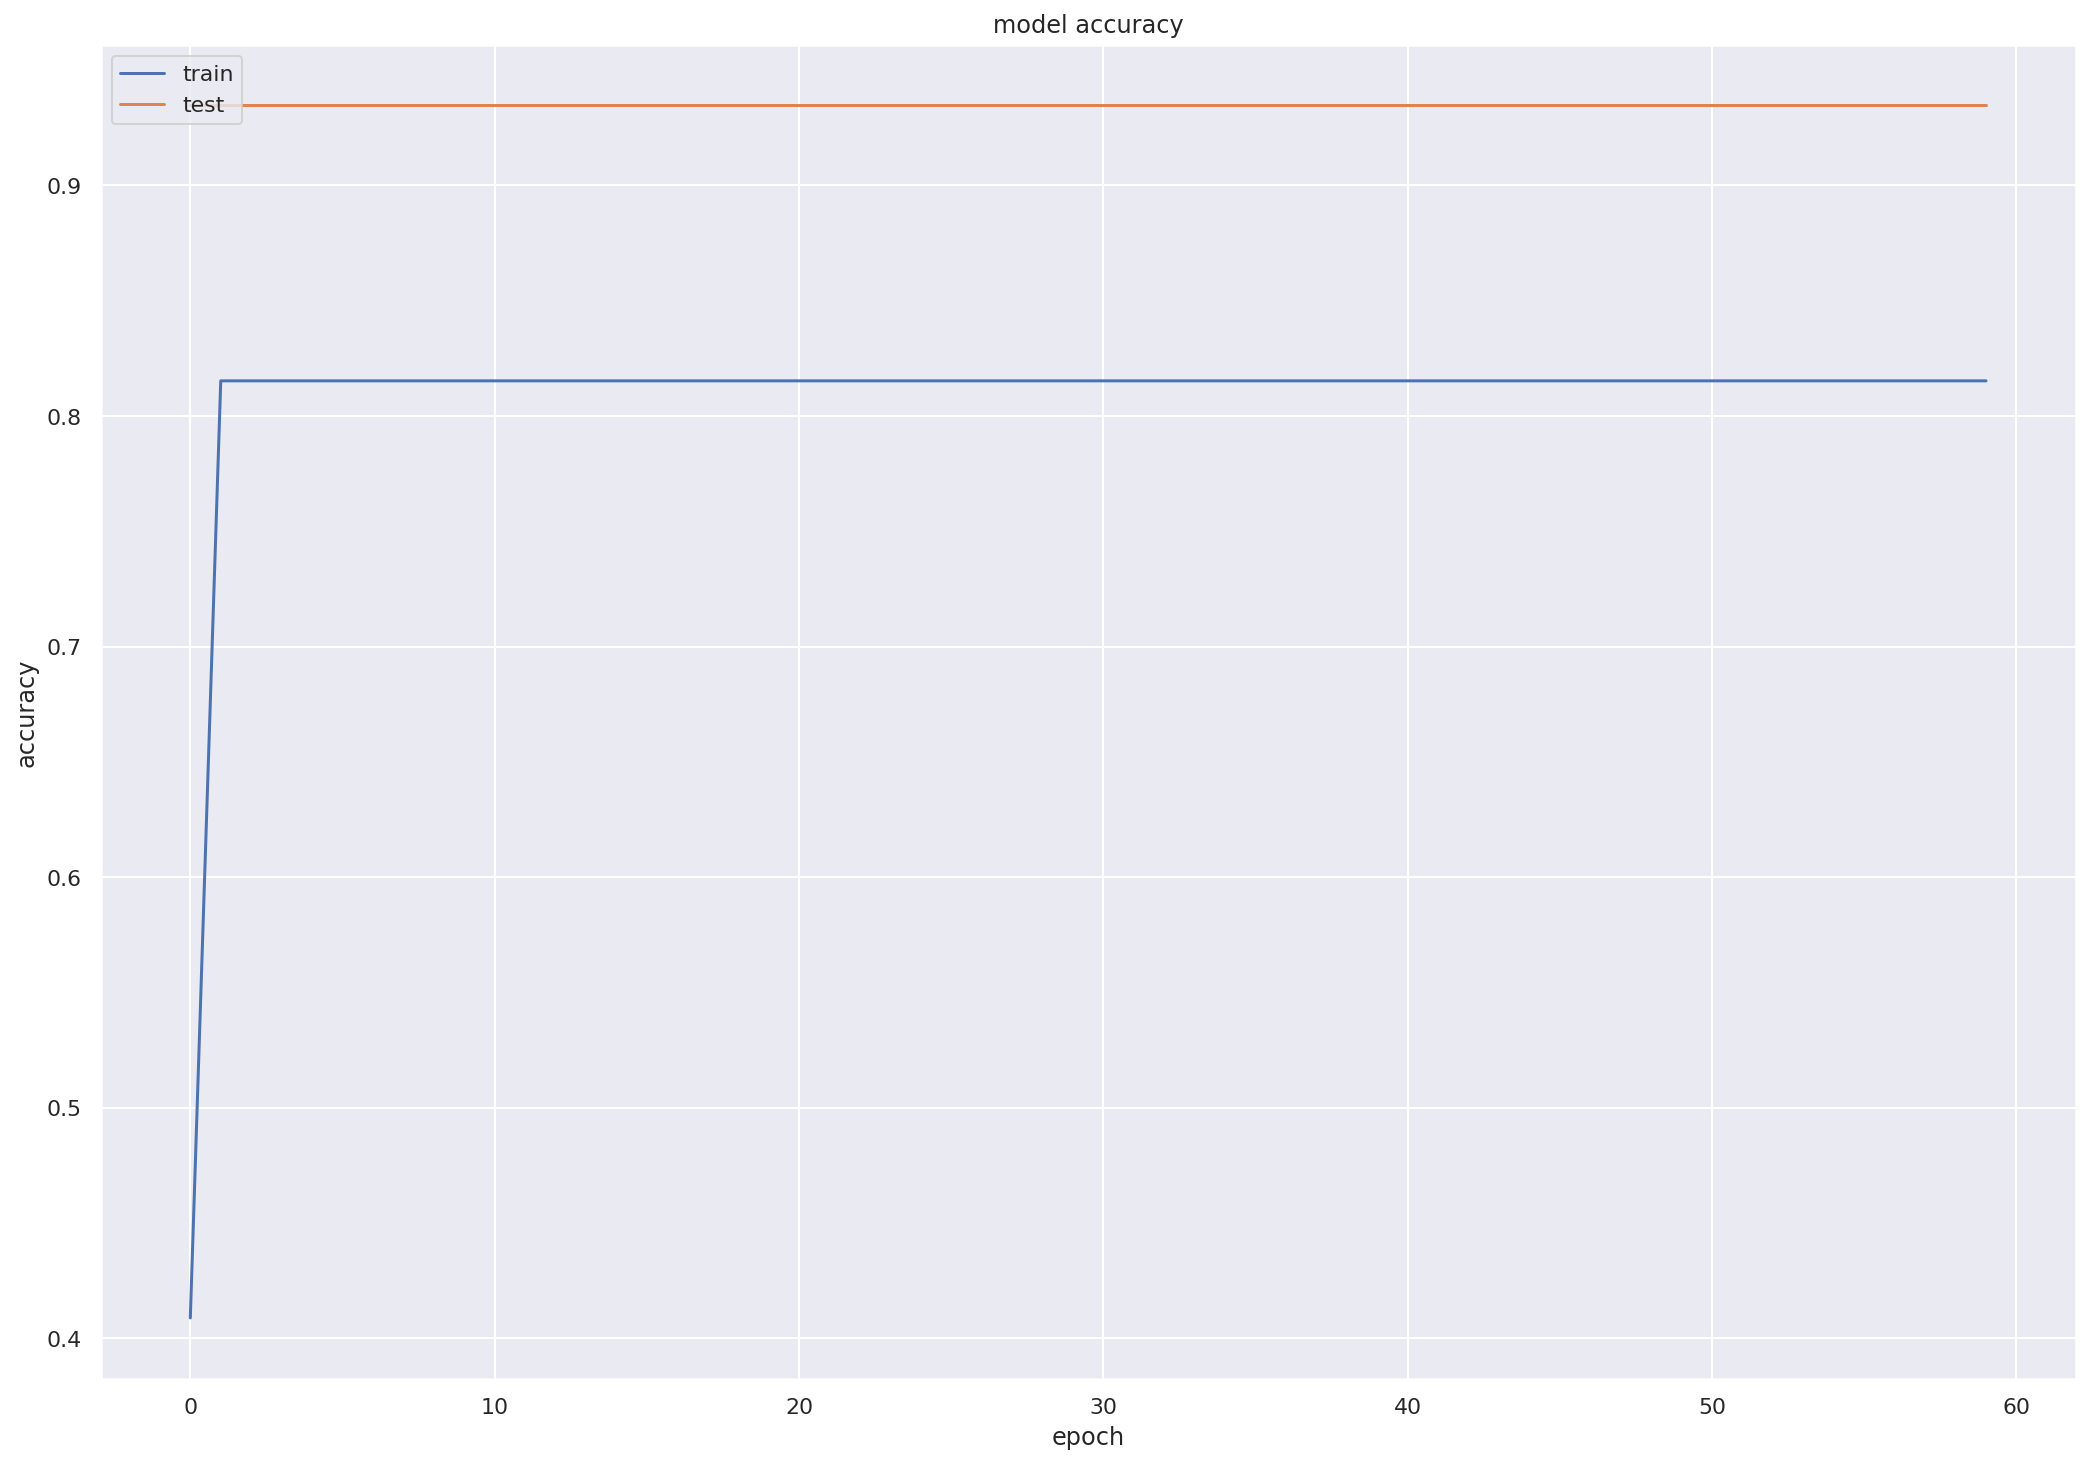

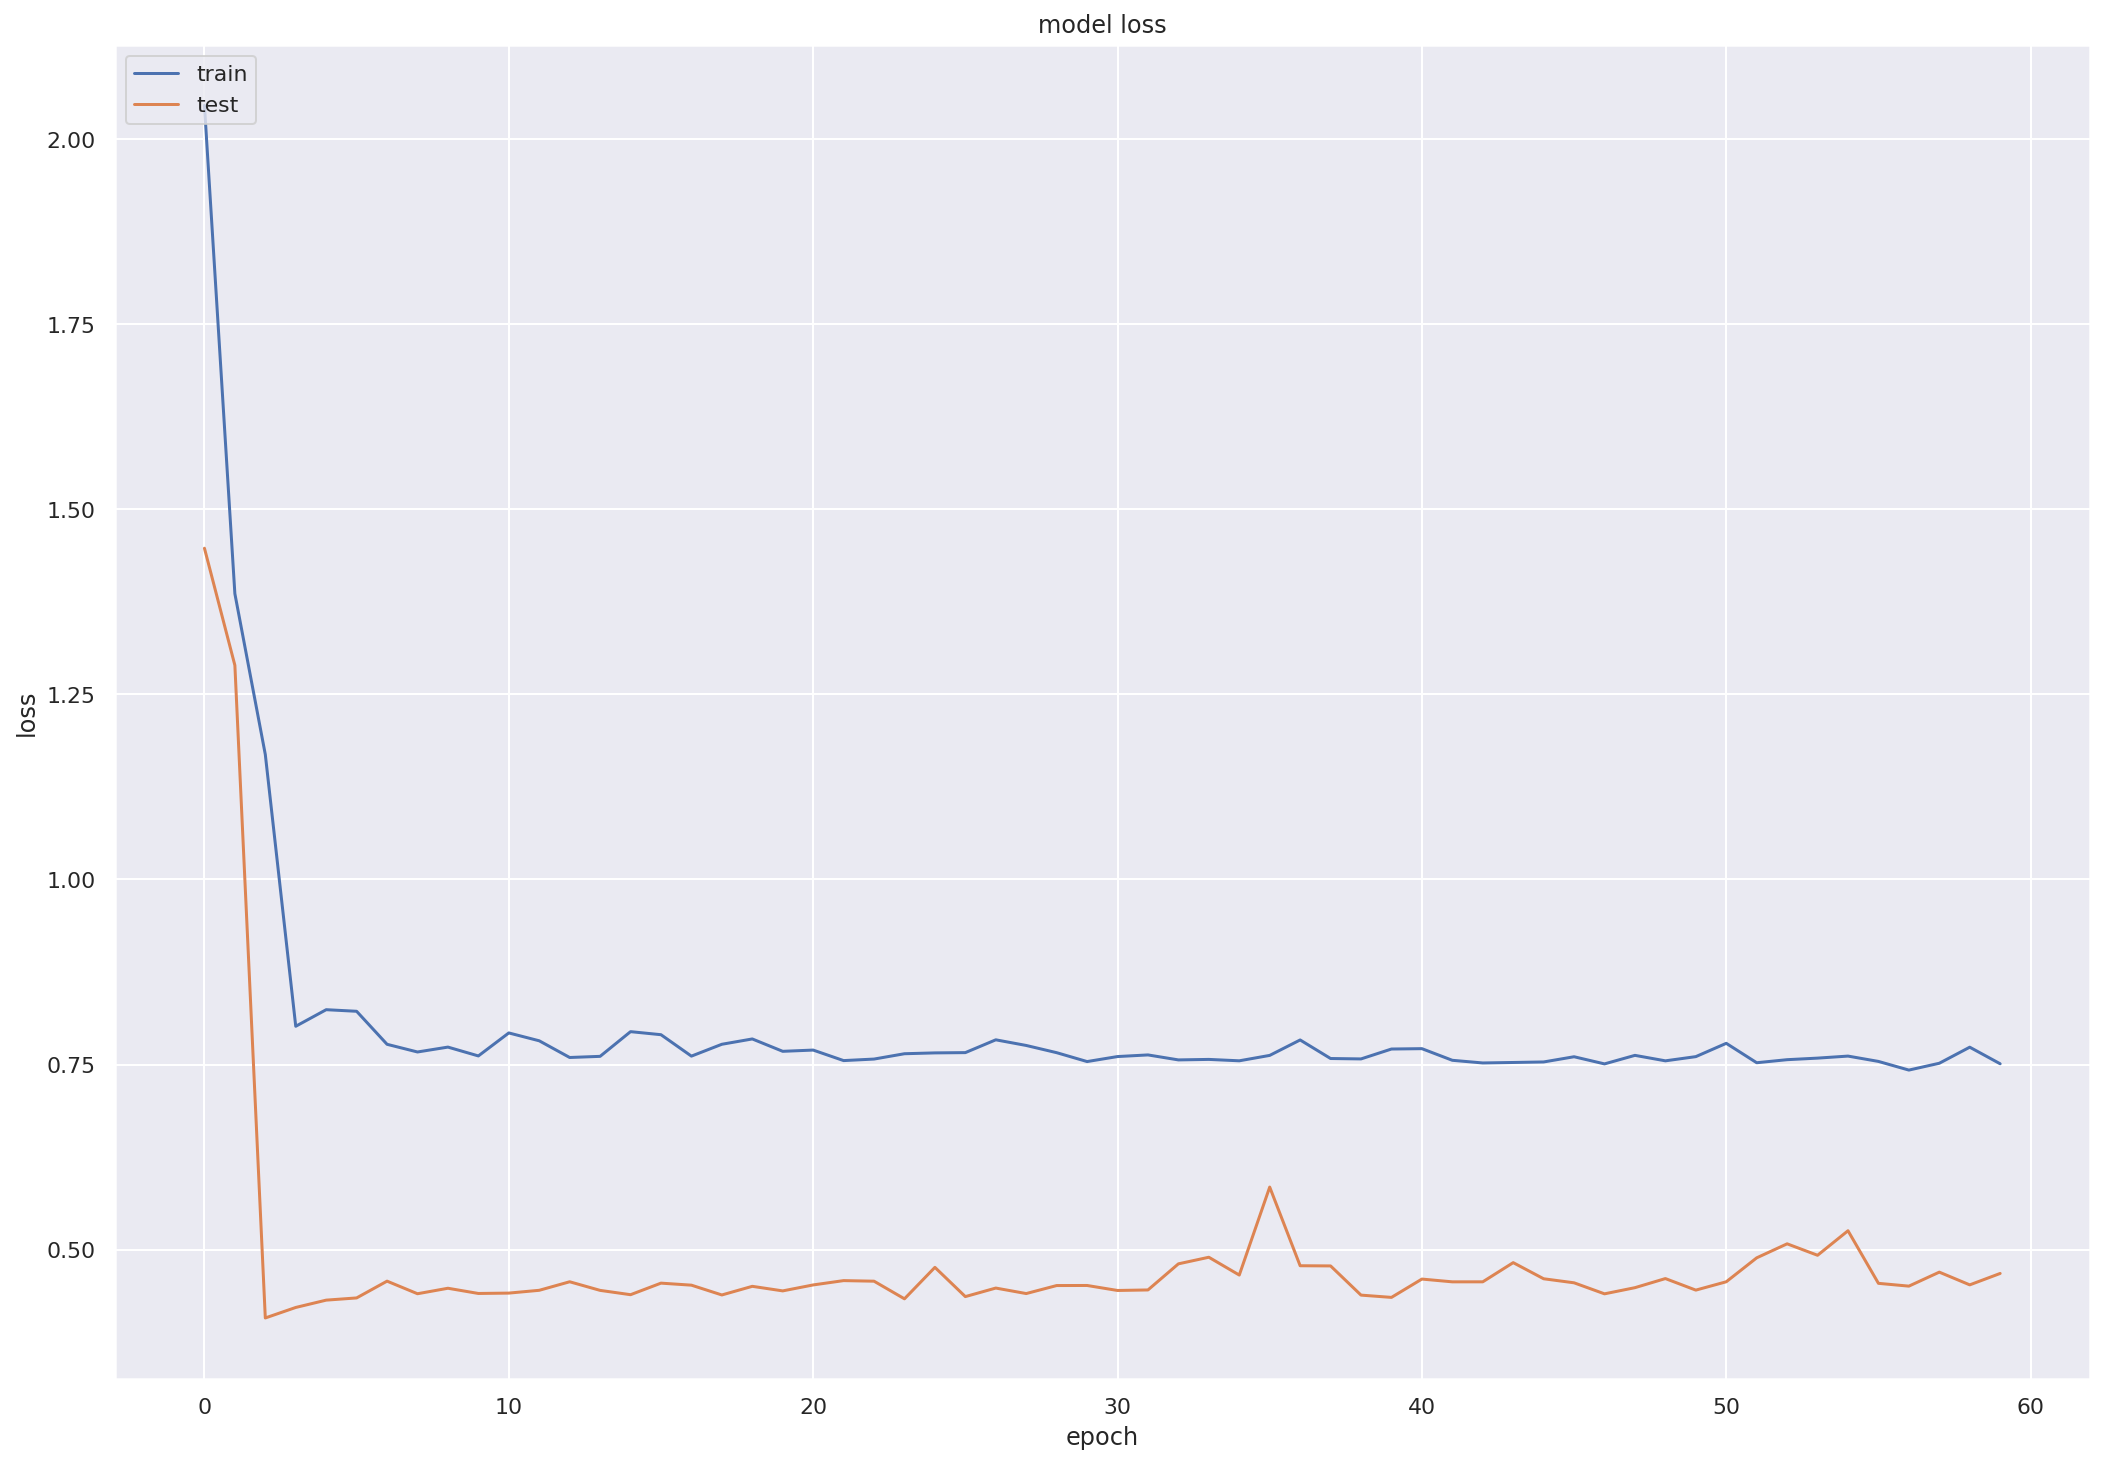

In [ ]:
# Train implementing callbacks

import keras

# Implementing callbacks to save model after each epoch, just in case not used by now cholo
savepath = "weights-stage-{epoch:02d}-{loss:.4f}-model.hdf5"    
checkpoint = keras.callbacks.ModelCheckpoint(
    savepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
history = modeld.fit(ninput, noutput, epochs=60, batch_size=512, validation_split=0.05)
scores = modeld.evaluate(ninput,noutput)

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#Save the model for duration
from keras.models import load_model

modeld.save('automusicDuration_model.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
noutput.shape

(1890, 12)

---

---


# Create the song via predictions to the notes and duration model

In [ ]:
reversedurationdict

{0: '0.25',
 1: '0.75',
 2: '1.0',
 3: '1/3',
 4: '2.0',
 5: '2.75',
 6: '3.0',
 7: '4.0'}

In [ ]:
import numpy as np
# Create the song with number of notes as specified in gnotes
gnotes = 400
songoutput = []
duraoutput = []
# Create starting numpy sequences for predicting notes and duration
#let's get a random index of the input sequences, for example:

#start = numpy.random.randint(0, len(ninput)-1)
#print("Random: ", start)
#seed = ninputclean[start]



#seeds of inital For The Love of God sequence durantion and notes.
seed = np.array([12, 27, 2, 13, 38, 28, 13])
seedd = np.array([4, 4, 4, 7, 4, 4, 3])
print("Inital seed for notes: ",seed) 


# Create reverse dictionary to make the translation from int to notes and duration
reversenotedict = dict((number, note) for number, note in enumerate(allnotes))
reversedurationdict = dict((number, duration) for number, duration in enumerate(allduration))


#insert the seed as part of the song and as part of the duration
# we want to "force" to a similar Em start as with Vai's For the love of god

for i in range(7):
    result = reversenotedict[seed[i]]
    songoutput.append(result)

for i in range(7):
    result = reversedurationdict[seedd[i]]
    duraoutput.append(result)


# Get the notes

loops = 0

for note_index in range(gnotes):
    prediction_input = numpy.reshape(seed, (1, len(seed), 1))
    prediction_input = prediction_input / float(vocab)
    prediction = model.predict(prediction_input, verbose=0)

  
        

# get the max. prob result in the output to reverse find the note
    ix = numpy.argmax(prediction)
    result = reversenotedict[ix]
    
# Let's avoid tonic notes on scale to get too present

    if  (len(songoutput) > 3 ): 
        if (result == songoutput[-2]):
            loops = loops + 1
            if (loops == 6):
                #Choose a random note of th dict
                rdnote = numpy.random.randint(0,vocab)
                result = reversenotedict[rdnote]
                loops = 0

# Write the notes
    print("Predicted: ", ix,"--",result)
    songoutput.append(result)


    
    
    
# Here slide the window on the seed to create a new seed with 10, including the last predicted note
    print("Seed before: ", seed)
    seed = np.append(seed,ix)
    print("Append: ", seed)
    seed = seed[1:len(seed)]
    print("Seed Window: ",seed)

print("SONG OUTPUT: ", songoutput)
print("=================================")
print("")




Inital seed for notes:  [12 27  2 13 38 28 13]
Predicted:  37 -- G3
Seed before:  [12 27  2 13 38 28 13]
Append:  [12 27  2 13 38 28 13 37]
Seed Window:  [27  2 13 38 28 13 37]
Predicted:  1 -- A3
Seed before:  [27  2 13 38 28 13 37]
Append:  [27  2 13 38 28 13 37  1]
Seed Window:  [ 2 13 38 28 13 37  1]
Predicted:  37 -- G3
Seed before:  [ 2 13 38 28 13 37  1]
Append:  [ 2 13 38 28 13 37  1 37]
Seed Window:  [13 38 28 13 37  1 37]
Predicted:  33 -- G#3
Seed before:  [13 38 28 13 37  1 37]
Append:  [13 38 28 13 37  1 37 33]
Seed Window:  [38 28 13 37  1 37 33]
Predicted:  26 -- F#3
Seed before:  [38 28 13 37  1 37 33]
Append:  [38 28 13 37  1 37 33 26]
Seed Window:  [28 13 37  1 37 33 26]
Predicted:  18 -- D4
Seed before:  [28 13 37  1 37 33 26]
Append:  [28 13 37  1 37 33 26 18]
Seed Window:  [13 37  1 37 33 26 18]
Predicted:  18 -- D4
Seed before:  [13 37  1 37 33 26 18]
Append:  [13 37  1 37 33 26 18 18]
Seed Window:  [37  1 37 33 26 18 18]
Predicted:  38 -- G4
Seed before:  [37  1 

In [ ]:

#NOW Let's get inferences on duration

# Get the duration


for note_index in range(gnotes):
    prediction_input = numpy.reshape(seedd, (1, len(seedd), 1))
    prediction_input = prediction_input / float(vocabd)
    prediction = modeld.predict(prediction_input, verbose=0)
    

# get the max. prob result in the output to reverse find the note
# For this demo, trim high duration notes (/4) and 0 duration, as they sound like chords

    ix = numpy.argmax(prediction)
    
    if ix > 4:
        ix = ix / 4
    if (ix  == 0) or (ix == 1):
        ix = numpy.random.randint(1,vocabd)
    if ix > 4:
        ix = ix / 4
        
    result = reversedurationdict[int(ix)]
    
# Let's avoid tonic notes on scale to get too present

    if  (len(duraoutput) > 3 ): 
        if (result == duraoutput[-2]):
            loops = loops + 1
            if (loops == 3):
                #Choose a random note of the dict
                rddura = numpy.random.randint(1,noutput.shape[1])
                result = reversedurationdict[rddura]
                loops = 0
                ix = rddura
    

# Add to the duration output
    duraoutput.append(result)
    
# Here slide the window on the seed to create a new seed with 10, including the last predicted note
    seedd = np.append(seedd,ix)
    seedd = seedd[1:len(seedd)]
    
print("DURATION GENERATED: ",duraoutput)

DURATION GENERATED:  ['2.0', '2.0', '2.0', '4.0', '2.0', '2.0', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3', '1/3'

## Build the song with the notes and duration predicted

In [ ]:
import music21
from music21 import instrument

finalsong = []

for element in range(gnotes):
    print("metiendo a nota: ",songoutput[element])
    loopnote = note.Note(songoutput[element])
    loopnote.storedInstrument = instrument.Guitar()
 
    print("metiendo a duracion: ",duraoutput[element])
    #if it is fraction, fix to the music21 format
    if "/" in duraoutput[element]:
        print("TRIPE; ",type(duraoutput[element]))
        x = str(duraoutput[element]).split('/')
        duraoutput[element] = int(x[0]) / int(x[1])
        print("DIVIDeD: ",duraoutput[element])
   
    
    #loopnote.quarterLength = float(2.0/3)
    
    loopnote.quarterLength = float(duraoutput[element])
    finalsong.append(loopnote)


metiendo a nota:  C#5
metiendo a duracion:  2.0
metiendo a nota:  F#4
metiendo a duracion:  2.0
metiendo a nota:  A4
metiendo a duracion:  2.0
metiendo a nota:  C3
metiendo a duracion:  4.0
metiendo a nota:  G4
metiendo a duracion:  2.0
metiendo a nota:  F2
metiendo a duracion:  2.0
metiendo a nota:  C3
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  G3
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  A3
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  G3
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  G#3
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  F#3
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  D4
metiendo a duracion:  1/3
TRIPE;  <class 'str'>
DIVIDeD:  0.3333333333333333
metiendo a nota:  D4
metiend

# Put all inside a Midi stream in Music21

In [ ]:
# Extract the parts from For the Love of God to add its backing track to the generated melody

import glob
from music21 import converter, instrument, note, chord, midi
 
#midi_path= "ForTheLoveofGod.mid"
midi_path= "/content/sample_data/MIDI/*.mid"

notes = []
chords = []
duration = []
notes_to_parse = None

for file in glob.glob(midi_path):
    print("--------------------------------------------")
    print("Reading midi file: ", file)
#Read MIDI

    mf = midi.MidiFile()
    mf.open(file)
    mf.read()
    
    
#List song parts
    midix = midi.translate.midiFileToStream(mf)
    partStream = midix.parts.stream()
    print("List of instruments found on MIDI file: ",file)
    for p in partStream:
        aux = p
        print(p.partName)

#info about the song

    parts = midix.parts.stream()
    #print("PARTS: ",parts.parts[1])

    print("Elements of the MIDI: ",midix.elements)
    print("Parts of the MIDI: ",parts)
    print("LEN parts:", len(parts))

#extracting the melody part 

    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes flat structure
        notes_to_parse = midi.flat.notes
    mf.close()

#parse notes,duration an chords


--------------------------------------------
Reading midi file:  /content/sample_data/MIDI/bach-bourree-in-e-minor-guitar.mid
List of instruments found on MIDI file:  /content/sample_data/MIDI/bach-bourree-in-e-minor-guitar.mid
None
Elements of the MIDI:  (<music21.stream.Part 0x7f7e7ce21940>,)
Parts of the MIDI:  <music21.stream.Score 0x7f7e7ce2c1d0>
LEN parts: 1
--------------------------------------------
Reading midi file:  /content/sample_data/MIDI/beethoven-tarrega-moonlight-sonata1-guitar.mid
List of instruments found on MIDI file:  /content/sample_data/MIDI/beethoven-tarrega-moonlight-sonata1-guitar.mid
None
Elements of the MIDI:  (<music21.stream.Part 0x7f7e7cbb6908>,)
Parts of the MIDI:  <music21.stream.Score 0x7f7e7cbb6198>
LEN parts: 1
--------------------------------------------
Reading midi file:  /content/sample_data/MIDI/brahms-lullaby-wiegenlied-guitar.mid
List of instruments found on MIDI file:  /content/sample_data/MIDI/brahms-lullaby-wiegenlied-guitar.mid
Guitar
Gui

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from music21 import stream, instrument

part = stream.Part()
part.append(finalsong)
part.insert(0, instrument.AcousticGuitar())

Songg = stream.Score()
Songg.insert(0, part)


p1 = stream.Part(id='Guitar')
#p1 = parts[1]




Songg.insert(1,p1)

Songg.write('midi', fp='R3-Automusic.mid')
#output_st = stream.Stream(finalsong)
#output_st.write('midi', fp='test_output.mid')



 

'R3-Automusic.mid'

In [ ]:
#12 12  0 22  1  1  1
seed = np.array([12, 12, 0, 22,1,1,1])
prediction_input = numpy.reshape(seed, (1, len(seed), 1))
prediction = modeld.predict(prediction_input, verbose=1)
ix = numpy.argmax(prediction)
print(ix)